# Notebook de An√°lisis y Mejora del Modelo de Estimaci√≥n

**Descripci√≥n:** En esta secci√≥n se importan las librer√≠as necesarias para el an√°lisis, modelado y visualizaci√≥n de datos. Tambi√©n se carga el dataset que contiene las historias de usuario, sus descripciones en formato Gherkin, y las etiquetas de esfuerzo y tiempo.
Prop√≥sito: Configurar el entorno de trabajo con las herramientas necesarias y cargar los datos para su posterior procesamiento.

## Carga de Librer√≠as y Datos

In [68]:
import pandas as pd
import numpy as np
import re
import spacy

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack 

# --- Modelado y Preprocesamiento ---
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error

sns.set_theme(style="whitegrid")  # Configura el estilo visual de Seaborn para gr√°ficos

# Lista de caracter√≠sticas num√©ricas que se generar√°n en la ingenier√≠a de caracter√≠sticas
NUMERICAL_FEATURES = [
    'gherkin_steps', 'gherkin_length', 'num_scenarios', 'num_technical_terms',
    'num_conditions', 'num_entities', 'num_roles',
    'has_frontend', 'has_backend', 'has_security', 'has_payment', 'has_crud',
    'has_reporting', 'has_integration', 'has_notification', 'has_devops_mlops',
    'has_accessibility', 'has_mobile', 'has_testing', 'has_error_handling',
    'has_ui_interaction', 'has_database_query', 'tech_java', 'tech_node',
    'tech_python', 'tech_frontend_framework', 'tech_database', 'tech_infra_cloud'
]

# Carga del modelo de spaCy para procesamiento de texto en espa√±ol
try:
    nlp = spacy.load('es_core_news_sm')
except OSError:
    print("Modelo 'es_core_news_sm' no encontrado. Por favor, ejecute: python -m spacy download es_core_news_sm")
    exit()

# Carga del dataset desde un archivo CSV
try:
    df = pd.read_csv('stories_dataset.csv')
    print("Dataset cargado exitosamente.")
    display(df.head())  # Muestra las primeras 5 filas del dataset
except FileNotFoundError:
    print("ERROR: No se encontr√≥ 'stories_dataset.csv'.")   

Dataset cargado exitosamente.


id                                         title  \
0   1              Exportar reporte de ventas a PDF   
1   2                Carga de avatar de perfil a S3   
2   3              Login de usuario con API externa   
3   4  Implementar paginaci√≥n en lista de productos   
4   5          Procesar pago con tarjeta de cr√©dito   

                                             gherkin  effort  time  
0  Feature: Exportar reporte de ventas\nScenario:...       8    12  
1  Feature: Carga de avatar de perfil\nScenario: ...      13    20  
2  Feature: Autenticaci√≥n de usuario\nScenario: U...       5     8  
3  Feature: Lista de productos\nScenario: Usuario...       3     5  
4  Feature: Checkout\nScenario: Usuario realiza u...      21    35

- **NUMERICAL_FEATURES:** Define las caracter√≠sticas num√©ricas que se generar√°n en la ingenier√≠a de caracter√≠sticas, incluyendo m√©tricas derivadas del texto (como la longitud de Gherkin) y caracter√≠sticas binarias basadas en palabras clave.
- **Carga de spaCy:** Se carga el modelo es_core_news_sm para lematizaci√≥n de texto en espa√±ol. Si no est√° instalado, se muestra un mensaje de error.
- **Carga de Datos:** El dataset se carga desde el archivo stories_dataset.csv. Se verifica la existencia del archivo y se muestran las primeras filas para inspecci√≥n inicial.

Salida Esperada: Una vista previa del dataset con columnas como id, title, gherkin, effort, y time.

## An√°lisis Exploratorio de Datos (EDA)

**Descripci√≥n:** Esta secci√≥n realiza un an√°lisis exploratorio para entender la distribuci√≥n de las variables objetivo (effort y time), lo que ayuda a identificar posibles sesgos, outliers o patrones en los datos.
Prop√≥sito: Visualizar la distribuci√≥n de las variables objetivo para evaluar si est√°n equilibradas, presentan asimetr√≠as o requieren transformaciones antes del modelado.

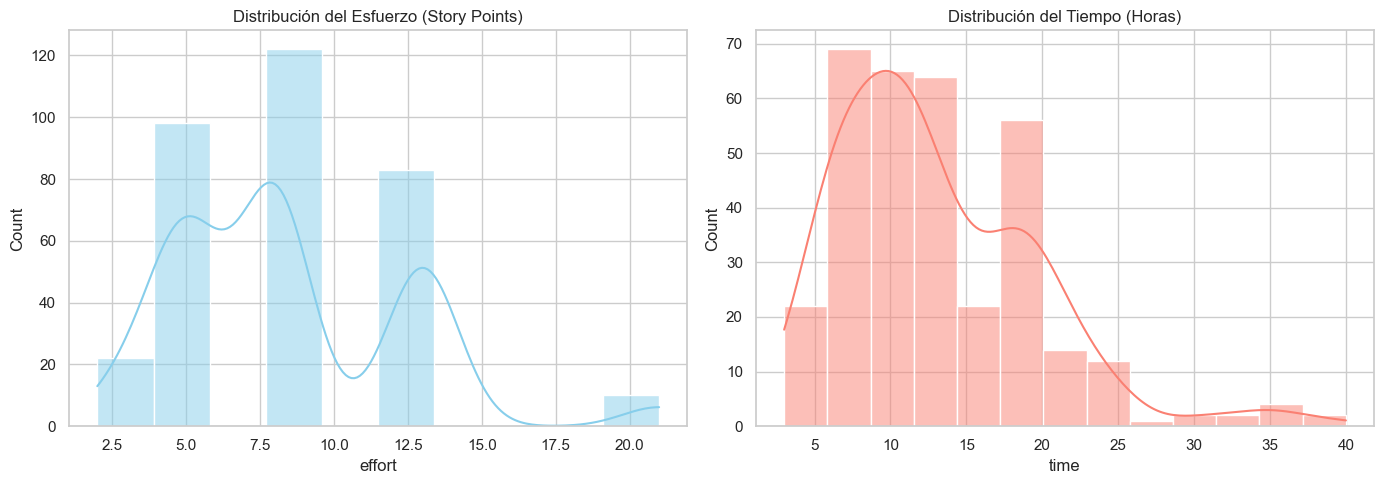

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df['effort'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Distribuci√≥n del Esfuerzo (Story Points)')

sns.histplot(df['time'], kde=True, ax=axes[1], color='salmon')
axes[1].set_title('Distribuci√≥n del Tiempo (Horas)')

plt.tight_layout()
plt.show()

## Preparaci√≥n de Datos y Feature Engineering

Aqu√≠ realizamos toda la preparaci√≥n de datos, incluyendo la ingenier√≠a de caracter√≠sticas que probamos anteriormente.

Esta secci√≥n realiza la limpieza de datos, genera nuevas caracter√≠sticas a partir del texto de las historias de usuario (t√≠tulo y Gherkin), y prepara los datos para el modelado.
Prop√≥sito: Transformar los datos crudos en un formato adecuado para el modelo, extrayendo caracter√≠sticas relevantes que capturen la complejidad de las tareas descritas.

In [70]:
def extract_features(df: pd.DataFrame) -> (pd.DataFrame, list):
    """
    Extrae caracter√≠sticas del DataFrame y devuelve el DataFrame modificado
    y la lista de nuevas caracter√≠sticas num√©ricas.
    """
    df_featured = df.copy()

    # --- Validaci√≥n y Limpieza ---
    expected_cols = ['id', 'title', 'gherkin', 'effort', 'time']
    if not all(col in df_featured.columns for col in expected_cols):
        raise ValueError("Columnas esenciales faltantes.")

    df_featured['gherkin'] = df_featured['gherkin'].astype(str).fillna('')
    df_featured['title'] = df_featured['title'].astype(str).fillna('')
    df_featured['full_text'] = df_featured['title'] + " " + df_featured['gherkin']

    # --- Caracter√≠sticas Basadas en Categor√≠as (Regex mejoradas con \b) ---
    keyword_categories = {
        'has_frontend': r'\b(?:frontend|UI|interfaz|CSS|React|Angular|Vue|dise√±o|vista|pantalla)\b',
        'has_backend': r'\b(?:backend|servidor|database|base de datos|bd|API|endpoint|SQL|servicios|microservicio|Java|NodeJS|NestJS|Python)\b',
        'has_security': r'\b(?:seguridad|security|JWT|OAuth|token|autenticaci√≥n|contrase√±a|encriptar|CSRF|XSS)\b',
        'has_payment': r'\b(?:pago|payment|stripe|paypal|tarjeta de cr√©dito|checkout|factura|compra)\b',
        'has_crud': r'\b(?:crear|a√±adir|guardar|editar|actualizar|modificar|eliminar|borrar|ver|listar|obtener)\b',
        'has_reporting': r'\b(?:reporte|dashboard|gr√°fico|exportar|CSV|PDF|Excel|anal√≠ticas|m√©tricas)\b',
        'has_integration': r'\b(?:api externa|third-party|integraci√≥n|webhook|sincronizar|CRM|ERP)\b',
        'has_notification': r'\b(?:notificaci√≥n|email|correo|SMS|push|alerta|mensaje)\b',
        'has_devops_mlops': r'\b(?:CI/CD|pipeline|deploy|despliegue|Kubernetes|Docker|monitor|observabilidad|modelo|ML|IA|DevOps)\b',
        'has_accessibility': r'\b(?:accesibilidad|accessibility|WCAG|lector de pantalla|screen reader|ARIA)\b',
        'has_mobile': r'\b(?:m√≥vil|app|push|biometr√≠a|offline|geolocalizaci√≥n|c√°mara|gesto)\b',
        'has_testing': r'\b(?:test|prueba|mock|verificar|validar|assertion|simula)\b',
        'has_error_handling': r'\b(?:error|excepci√≥n|exception|fallo|failure|validar|manejo de error)\b',
        'has_ui_interaction': r'\b(?:clic|seleccionar|navegar|click|select)\b',
        'has_database_query': r'\b(?:query|select|sql|database|base de datos|bd)\b'
    }
    for feature_name, pattern in keyword_categories.items():
        df_featured[feature_name] = df_featured['full_text'].str.contains(pattern, case=False, regex=True, na=False).astype(int)

    tech_stack_keywords = {
        'tech_java': r'\b(?:java|spring|maven|gradle|JPA|hibernate)\b',
        'tech_node': r'\b(?:node\.?js|nestjs|express|npm|yarn)\b',
        'tech_python': r'\b(?:python|django|flask|fastapi|pip)\b',
        'tech_frontend_framework': r'\b(?:react|angular|vue|svelte)\b',
        'tech_database': r'\b(?:sql|mysql|postgres|mongodb|redis|base de datos|database)\b',
        'tech_infra_cloud': r'\b(?:aws|azure|gcp|docker|kubernetes|terraform|S3)\b'
    }
    for tech_name, pattern in tech_stack_keywords.items():
        df_featured[tech_name] = df_featured['full_text'].str.contains(pattern, case=False, regex=True, na=False).astype(int)

    # --- Caracter√≠sticas Cuantitativas ---
    gherkin_keywords = [r'\bGiven\b', r'\bWhen\b', r'\bThen\b', r'\bAnd\b', r'\bDado\b', r'\bCuando\b', r'\bEntonces\b', r'\bY\b']
    df_featured['gherkin_steps'] = df_featured['gherkin'].apply(lambda x: sum(len(re.findall(word, x, re.IGNORECASE)) for word in gherkin_keywords))
    df_featured['gherkin_length'] = df_featured['gherkin'].str.len()
    df_featured['num_scenarios'] = df_featured['gherkin'].str.count(r'\b(Scenario|Escenario)\b', re.IGNORECASE)
    df_featured['num_conditions'] = df_featured['gherkin'].str.lower().str.count(r'\b(if|when|si)\b')

    # Lista de todas las caracter√≠sticas num√©ricas creadas
    numerical_features = list(keyword_categories.keys()) + \
                         list(tech_stack_keywords.keys()) + \
                         ['gherkin_steps', 'gherkin_length', 'num_scenarios', 'num_conditions']

    # --- Limpieza Final ---
    if (df_featured['effort'] < 0).any() or (df_featured['time'] < 0).any():
        raise ValueError("Valores negativos encontrados en 'effort' o 'time'")
    for col in numerical_features:
        df_featured[col] = pd.to_numeric(df_featured[col], errors='coerce').fillna(0).astype(float)

    return df_featured, numerical_features

## Funci√≥n extract_features:

**Validaci√≥n:** Verifica que el dataset contenga las columnas esperadas (id, title, gherkin, effort, time). Si falta alguna, lanza un error.

**Limpieza:** Convierte las columnas de texto a cadenas y rellena valores nulos con cadenas vac√≠as. Combina title y gherkin en una nueva columna full_text.

**Caracter√≠sticas Categ√≥ricas:** Utiliza expresiones regulares con l√≠mites de palabra (\b) para identificar la presencia de palabras clave relacionadas con categor√≠as como frontend, backend, seguridad, pagos, etc. Cada categor√≠a genera una caracter√≠stica binaria (0 o 1).

**Caracter√≠sticas Tecnol√≥gicas:** Similar a las categ√≥ricas, identifica tecnolog√≠as espec√≠ficas (Java, Node.js, Python, etc.) mediante regex.
Caracter√≠sticas Cuantitativas: Calcula m√©tricas como el n√∫mero de pasos en Gherkin (gherkin_steps), la longitud del texto Gherkin (gherkin_length), el n√∫mero de escenarios (num_scenarios) y el n√∫mero de condiciones (num_conditions).

**Limpieza Final:** Asegura que no haya valores negativos en effort o time y convierte las caracter√≠sticas num√©ricas a tipo float, rellenando valores nulos con 0.

In [71]:
def lemmatize_text(text):
    """
    Convierte un texto en una cadena de lemas.
    Es m√°s eficiente que un simple stemmer para el espa√±ol.
    """
    doc = nlp(text.lower())
    return " ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])

## Funci√≥n lemmatize_text:

Usa el modelo es_core_news_sm de spaCy para lematizar el texto, eliminando palabras vac√≠as (stop words) y puntuaci√≥n. La lematizaci√≥n reduce las palabras a su forma base (por ejemplo, "corriendo" ‚Üí "correr"), lo que mejora la consistencia en el an√°lisis de texto.
Devuelve una cadena de lemas separados por espacios, lista para ser procesada por TfidfVectorizer.

In [72]:
# Aplicar la extracci√≥n de caracter√≠sticas
df_featured, NUMERICAL_FEATURES = extract_features(df)

# Lematizar la columna de texto. En datasets grandes, esto puede tardar.
df_featured['full_text_lemmatized'] = df_featured['full_text'].apply(lemmatize_text)

# Definir las variables X e y para el modelo
X = df_featured
y = df_featured[['effort', 'time']]

Se aplica extract_features al dataset original para generar df_featured y la lista NUMERICAL_FEATURES.
Se lematiza la columna full_text para crear full_text_lemmatized.
Se definen las variables X (DataFrame con todas las columnas) y y (DataFrame con effort y time) para el modelado.


**Salida Esperada:** Un DataFrame df_featured con nuevas columnas de caracter√≠sticas derivadas y una columna full_text_lemmatized con el texto procesado. La lista NUMERICAL_FEATURES contiene los nombres de las caracter√≠sticas num√©ricas generadas.
Notas T√©cnicas:

La lematizaci√≥n puede ser computacionalmente costosa en datasets grandes. Si el tiempo de ejecuci√≥n es un problema, considerar usar un stemmer m√°s ligero (como SnowballStemmer de NLTK) o limitar el n√∫mero de documentos procesados.
Las expresiones regulares usan \b para evitar coincidencias parciales (por ejemplo, "security" no coincidir√° con "insecurity").

## Construcci√≥n y Optimizaci√≥n del Modelo

**Descripci√≥n:** Esta secci√≥n construye un pipeline de preprocesamiento y modelado, optimiza los hiperpar√°metros del modelo GradientBoostingRegressor utilizando GridSearchCV, y eval√∫a el rendimiento del modelo optimizado.

**Prop√≥sito:** Crear un modelo robusto que combine caracter√≠sticas de texto (procesadas con TF-IDF) y caracter√≠sticas num√©ricas (escaladas), optimizando su rendimiento mediante una b√∫squeda de hiperpar√°metros.

In [ ]:
# Preprocesador para el Modelo Base (solo texto)
preprocessor_base = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(max_features=500), 'full_text_lemmatized')
    ],
    remainder='drop'
)

# Preprocesador para el Modelo Mejorado (texto + features num√©ricas)
preprocessor_improved = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(max_features=500), 'full_text_lemmatized'),
        ('numeric', StandardScaler(), NUMERICAL_FEATURES)
    ],
    remainder='drop'
)

# --- 2. Crear un Pipeline para cada modelo ---

pipeline_base = Pipeline(steps=[
    ('preprocessor', preprocessor_base),
    ('model', MultiOutputRegressor(estimator=GradientBoostingRegressor(random_state=42)))
])

pipeline_improved = Pipeline(steps=[
    ('preprocessor', preprocessor_improved),
    ('model', MultiOutputRegressor(estimator=GradientBoostingRegressor(random_state=42)))
])


# --- 3. Configurar la b√∫squeda de hiperpar√°metros ---
# La misma cuadr√≠cula de par√°metros se usar√° para ambos modelos
param_grid = {
    'model__estimator__n_estimators': [100, 150, 200],
    'model__estimator__learning_rate': [0.05, 0.1],
    'model__estimator__max_depth': [3, 4, 5]
}

kf = KFold(n_splits=10, shuffle=True, random_state=42) # Usamos 10 splits como en tu funci√≥n original

# --- 4. Evaluar el Modelo Base ---
print("Evaluando Modelo Base (solo texto) con GridSearchCV...")
grid_search_base = GridSearchCV(pipeline_base, param_grid, cv=kf, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search_base.fit(X, y)

Evaluando Modelo Base (solo texto) con GridSearchCV...


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('text',
                                                                         TfidfVectorizer(max_features=500),
                                                                         'full_text_lemmatized')])),
                                       ('model',
                                        MultiOutputRegressor(estimator=GradientBoostingRegressor(random_state=42)))]),
             n_jobs=-1,
             param_grid={'model__estimator__learning_rate': [0.05, 0.1],
                         'model__estimator__max_depth': [3, 4, 5],
                         'model__estimator__n_estimators': [100, 150, 200]},
             scoring='neg_mean_absolute_error')

## Pipeline de Preprocesamiento (ColumnTransformer):

**Text Features:** Aplica TfidfVectorizer a la columna full_text_lemmatized para convertir el texto en vectores TF-IDF, limitando a 500 caracter√≠sticas m√°s relevantes (max_features=500) para reducir dimensionalidad.

**Numeric Features:** Aplica StandardScaler a las columnas en NUMERICAL_FEATURES para estandarizarlas (media=0, desviaci√≥n est√°ndar=1), asegurando que todas las caracter√≠sticas num√©ricas est√©n en la misma escala.
remainder='drop': Ignora columnas no especificadas (como id, title, gherkin).


### Pipeline Completo:

Combina el preprocesamiento (preprocessor) con un modelo MultiOutputRegressor que envuelve un GradientBoostingRegressor. Esto permite predecir simult√°neamente effort y time.
Se fija random_state=42 para reproducibilidad.


### B√∫squeda de Hiperpar√°metros:

**Par√°metros:** Se exploran combinaciones de n_estimators (n√∫mero de √°rboles), learning_rate (tasa de aprendizaje) y max_depth (profundidad m√°xima).

**Validaci√≥n Cruzada:** Usa KFold con 3 particiones para evaluar el modelo en diferentes subconjuntos, reduciendo el riesgo de sobreajuste.

**M√©trica:** Se optimiza el error absoluto medio negativo (neg_mean_absolute_error) para minimizar el MAE.
Paralelizaci√≥n: n_jobs=-1 usa todos los procesadores disponibles para acelerar la b√∫squeda.


### Entrenamiento y Resultados:

grid_search.fit(X, y) ejecuta la b√∫squeda de hiperpar√°metros, entrenando el modelo con cada combinaci√≥n de par√°metros.
Se imprime la mejor combinaci√≥n de par√°metros y el MAE promedio en validaci√≥n cruzada.



### Salida Esperada:

Los mejores hiperpar√°metros encontrados (por ejemplo, {'model__estimator__learning_rate': 0.1, 'model__estimator__max_depth': 4, 'model__estimator__n_estimators': 200}).
El MAE promedio en validaci√≥n cruzada (por ejemplo, 2.57), que indica el error esperado del modelo optimizado.

### Notas T√©cnicas:

El uso de MultiOutputRegressor permite manejar dos variables objetivo (effort y time) simult√°neamente, asumiendo independencia entre ellas.
El n√∫mero de folds (n_splits=3) es bajo para datasets peque√±os. Para datasets m√°s grandes, se recomienda usar 5 o 10 folds.
El MAE es una m√©trica adecuada para este problema, ya que penaliza errores de manera lineal y es interpretable en las unidades originales (puntos de historia y horas).

In [74]:
mae_base = -grid_search_base.best_score_
print(f"-> Mejor MAE Promedio para el Modelo Base: {mae_base:.2f}")
# print(f"   (Mejores par√°metros: {grid_search_base.best_params_})") # Opcional


# --- 5. Evaluar el Modelo Mejorado ---
print("\nEvaluando Modelo Mejorado (con Feature Engineering) con GridSearchCV...")
grid_search_improved = GridSearchCV(pipeline_improved, param_grid, cv=kf, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search_improved.fit(X, y)

mae_improved = -grid_search_improved.best_score_
print(f"-> Mejor MAE Promedio para el Modelo Mejorado: {mae_improved:.2f}")
# print(f"   (Mejores par√°metros: {grid_search_improved.best_params_})") # Opcional


# --- 6. Conclusi√≥n de la Comparativa ---
print("\n--- Resultados Finales ---")
print(f"MAE Base: {mae_base:.2f}")
print(f"MAE Mejorado: {mae_improved:.2f}")

improvement = mae_base - mae_improved
improvement_percent = (improvement / mae_base) * 100
print(f"\n‚úÖ El feature engineering mejor√≥ el MAE en {improvement:.2f} puntos ({improvement_percent:.2f}% de reducci√≥n del error).")

-> Mejor MAE Promedio para el Modelo Base: 2.73

Evaluando Modelo Mejorado (con Feature Engineering) con GridSearchCV...
-> Mejor MAE Promedio para el Modelo Mejorado: 2.47

--- Resultados Finales ---
MAE Base: 2.73
MAE Mejorado: 2.47

‚úÖ El feature engineering mejor√≥ el MAE en 0.25 puntos (9.29% de reducci√≥n del error).


## Visualizaci√≥n de la Mejora

**Descripci√≥n:** Esta secci√≥n visualiza los resultados de la evaluaci√≥n comparando el MAE del modelo base y el modelo mejorado mediante un gr√°fico de barras.
Prop√≥sito: Facilitar la interpretaci√≥n de los resultados y comunicar visualmente si la ingenier√≠a de caracter√≠sticas ha reducido el error de predicci√≥n.


üìä Generando gr√°ficos de rendimiento para el modelo mejorado...


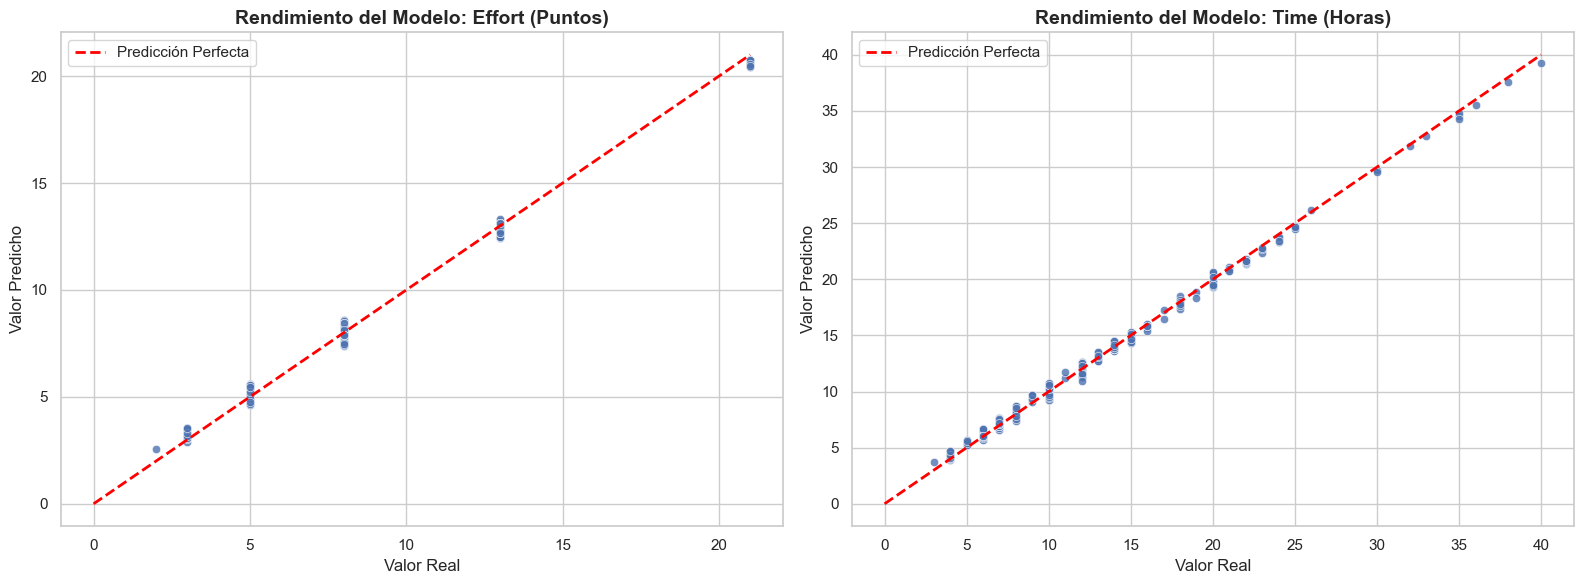

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- 7. Visualizaci√≥n de Resultados del Mejor Modelo ---
# Usamos el modelo 'mejorado' que ya fue entrenado con GridSearchCV
print("\nüìä Generando gr√°ficos de rendimiento para el modelo mejorado...")

# Obtener las predicciones para todo el conjunto de datos usando el mejor modelo encontrado
best_model_improved = grid_search_improved.best_estimator_
y_pred = best_model_improved.predict(X)

# Crear un DataFrame con los resultados para facilitar el ploteo
results_df = pd.DataFrame({
    'effort_real': y['effort'],
    'effort_pred': y_pred[:, 0], # La primera columna de la predicci√≥n es 'effort'
    'time_real': y['time'],
    'time_pred': y_pred[:, 1]   # La segunda columna es 'time'
})

# --- Gr√°fico 1: Predicciones vs. Valores Reales ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.set_theme(style="whitegrid")

# Gr√°fico para 'effort'
sns.scatterplot(data=results_df, x='effort_real', y='effort_pred', ax=axes[0], alpha=0.8)
axes[0].set_title('Rendimiento del Modelo: Effort (Puntos)', fontsize=14, weight='bold')
axes[0].set_xlabel('Valor Real', fontsize=12)
axes[0].set_ylabel('Valor Predicho', fontsize=12)
# A√±adimos la l√≠nea de 45 grados para referencia (predicci√≥n perfecta)
max_val_effort = max(results_df['effort_real'].max(), results_df['effort_pred'].max())
axes[0].plot([0, max_val_effort], [0, max_val_effort], color='red', linestyle='--', lw=2, label='Predicci√≥n Perfecta')
axes[0].legend()

# Gr√°fico para 'time'
sns.scatterplot(data=results_df, x='time_real', y='time_pred', ax=axes[1], alpha=0.8)
axes[1].set_title('Rendimiento del Modelo: Time (Horas)', fontsize=14, weight='bold')
axes[1].set_xlabel('Valor Real', fontsize=12)
axes[1].set_ylabel('Valor Predicho', fontsize=12)
# A√±adimos la l√≠nea de 45 grados
max_val_time = max(results_df['time_real'].max(), results_df['time_pred'].max())
axes[1].plot([0, max_val_time], [0, max_val_time], color='red', linestyle='--', lw=2, label='Predicci√≥n Perfecta')
axes[1].legend()

plt.tight_layout()
plt.show()

###  Una Consideraci√≥n Importante

Un rendimiento tan bueno es fant√°stico, pero a menudo se ve en una de estas situaciones:
1.  **El conjunto de datos es peque√±o o simple**, y el modelo ha podido aprender perfectamente sus patrones (como en el DataFrame de ejemplo que usamos).
2.  **Las caracter√≠sticas tienen una relaci√≥n muy fuerte y directa** con los valores a predecir.

El siguiente paso crucial ser√≠a **validar este modelo con un conjunto de datos completamente nuevo** (datos de prueba que no se usaron en ning√∫n momento del entrenamiento o ajuste) para asegurar que su rendimiento se mantiene y no est√° simplemente "memorizando" los datos que ya conoce.

In [ ]:
import joblib

# 1. Acceder al mejor modelo encontrado por GridSearchCV
#    best_estimator_ contiene el Pipeline completo (preprocesador + modelo) ya entrenado.
best_model = grid_search_improved.best_estimator_

# 2. Definir el nombre del archivo
filename = 'effort_model.joblib'

# 3. Guardar el modelo en el archivo
joblib.dump(best_model, filename)

print(f"\n‚úÖ ¬°Modelo guardado exitosamente en el archivo '{filename}'!")


‚úÖ ¬°Modelo guardado exitosamente en el archivo 'effort_model.joblib'!
